In [26]:
import gensim
from gensim.models import KeyedVectors
from gensim.models.fasttext import FastText as FT_gensim
import pandas as pd
import numpy as np
import pickle
from wiki import Wiki,Revision
from sklearn.metrics import  silhouette_score
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

In [2]:
def get_word_vecs(wiki_vec, tokens):
    in_vocab_tokens = set(tokens) & set(wiki_vec.vocab)
    if in_vocab_tokens:
        return wiki_vec[in_vocab_tokens].sum(axis=0, keepdims=True)
    else:
        return np.zeros((1, wiki_vec.vector_size))

In [3]:
wiki_vec = KeyedVectors.load_word2vec_format('../wordvectors/wiki.en.vec', binary=False, limit=50000)

### reading the change object and clustering.

In [4]:
%%time
content = "Violence_against_Muslims_in_India"
with open(content+".pkl", "rb") as file:
    wiki = pickle.load(file)

CPU times: user 8.02 s, sys: 37.3 s, total: 45.3 s
Wall time: 48 s


In [5]:
%%time
change_objects = []
wiki.revisions.iloc[:-1].apply(lambda revision: change_objects.append(revision.neighbour))
change_index = [ rev.id for rev in  wiki.revisions[:-1].tolist()]
change_df = pd.concat(change_objects, sort=False, keys=change_index)


CPU times: user 212 ms, sys: 24 ms, total: 236 ms
Wall time: 235 ms


In [6]:
timestamp_s = pd.to_datetime([ rev.timestamp for rev in  wiki.revisions.values.ravel().tolist()])
time_gap = pd.to_timedelta(timestamp_s[1:]-timestamp_s[:-1])
editor_s = [ rev.id for rev in  wiki.revisions.tolist()]
index = list(zip(*[timestamp_s.tolist()[:-1], time_gap, editor_s[:-1]]))
change_df = pd.concat(change_objects, sort=False, keys=index, names=["timestamp", "timegap", "editor"])

In [7]:
for i in range(len(change_objects)):
    change_objects[i]["timestamp"] = timestamp_s[i+1]
    change_objects[i]["time_gap"] = time_gap[i]
    change_objects[i]["editor_s"] = editor_s[i+1]
change_df = pd.concat(change_objects, sort=False, keys=wiki.revisions[:-1].index)

### Make left, ins and delete string for visualisation

In [8]:
change_df["left_string"] = change_df["left_token"].str.join(" ")
change_df["ins_string"] = change_df["ins_tokens"].str.join(" ")
change_df["del_string"] = change_df["del_tokens"].str.join(" ")
change_df["right_string"] = change_df["right_token"].str.join(" ")

In [9]:
change_df["ins_token_len"]=change_df["ins_tokens"].str.len()
change_df["del_token_len"]=change_df["del_tokens"].str.len()

In [10]:
%%time
ins_vec_list = []
change_df["ins_tokens"].apply(lambda token_set: ins_vec_list.append(get_word_vecs(wiki_vec, token_set)))
ins_matrix = np.concatenate(ins_vec_list, axis=0)

del_vec_list = []
change_df["del_tokens"].apply(lambda token_set: del_vec_list.append(get_word_vecs(wiki_vec, token_set)))
del_matrix = np.concatenate(del_vec_list, axis=0)

left_vec_list = []
change_df["left_token"].apply(lambda token_set: left_vec_list.append(get_word_vecs(wiki_vec, token_set)))
left_neighbour_matrix = np.concatenate(left_vec_list, axis=0)

right_vec_list = []
change_df["right_token"].apply(lambda token_set: right_vec_list.append(get_word_vecs(wiki_vec, token_set)))
right_neighbour_matrix = np.concatenate(right_vec_list, axis=0)

CPU times: user 41.8 s, sys: 568 ms, total: 42.4 s
Wall time: 42.4 s


In [15]:
ins_del_matrix = np.concatenate([ins_matrix, del_matrix], axis=1)
neighbour_matrix = np.concatenate([right_neighbour_matrix, left_neighbour_matrix], axis=1)
change_neighbour_matrix = np.concatenate([left_neighbour_matrix, ins_del_matrix, right_neighbour_matrix], axis=1)
ins_del_sum_matrix = ins_matrix + del_matrix
ins_del_sum_neighbour_matrix = np.concatenate([left_neighbour_matrix, ins_del_sum_matrix, right_neighbour_matrix], axis=1)

### Do clustering

In [16]:
from sklearn.cluster import KMeans

In [17]:
silhoutee_s = []
for n in range(2,48,2):
    km = KMeans(n_clusters= n, n_jobs=3)
    clusters = km.fit(ins_del_sum_neighbour_matrix)
    cluster_s = pd.Series(clusters.labels_, index= change_df.index)
    silhoutee_s.append(silhouette_score(change_neighbour_matrix, cluster_s))

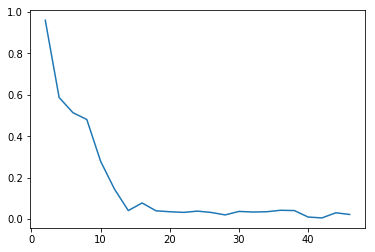

In [18]:
x = np.arange(2,48,2)
plt.plot(x,silhoutee_s)

In [19]:
x[np.argsort(silhoutee_s)[-8:]]

array([36, 16, 12, 10,  8,  6,  4,  2])

In [20]:
np.array(silhoutee_s)[np.argsort(silhoutee_s)[-8:]]

array([0.04248688, 0.0777236 , 0.14477684, 0.27867676, 0.48050433,
       0.51327551, 0.58663063, 0.95941773])

In [68]:
%%time
NO_OF_CLUSTERS= 20
km = KMeans(n_clusters= NO_OF_CLUSTERS, n_jobs=3)
clusters = km.fit(change_neighbour_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_tokens = change_df.groupby("cluster")
change_grouped_by_tokens.size()

CPU times: user 2.17 s, sys: 624 ms, total: 2.79 s
Wall time: 14.6 s


In [69]:
pd.get_option("display.max_columns")
pd.set_option('max_colwidth',40000)

In [70]:
change_grouped_by_tokens.size()

cluster
0      912
1        2
2        4
3       11
4        9
5      191
6      170
7        2
8       17
9     1351
10      39
11       1
12      23
13     175
14      49
15      55
16       4
17       2
18     714
19     134
dtype: int64

In [92]:
style_dict = {'border': "2px solid #000",
              "text-align": "justify"
    
}

In [101]:
repers = [ change_grouped_by_tokens[["left_string","del_string", "ins_string", "right_string"]].get_group(i).style.set_properties(**style_dict, axis=None).set_caption("group "+ str(i) ).render() for i in range(NO_OF_CLUSTERS)]

In [102]:
all_html = " ".join(repers)
with open(content + str(NO_OF_CLUSTERS) + ".html", 'wb') as f:
    f.write(all_html.encode())

In [103]:
a= HTML(repers[0])
for repr in repers:
    display(HTML( "<br/><br/><br/>"+repr ))

In [100]:
HTML( repers[12] )

### Ranking
###### Ranking clustered groups on following parameters.
1. Size of clusters
2. No of unique editors is clusters
3. Total period of cluster. i.e difference between start and end date.
4. Median length of edited token in each cluster.

In [ ]:
rank_by_size = change_grouped_by_tokens.size().sort_values()
rank_by_size

In [72]:
rank_by_uniq_editor = change_grouped_by_tokens["editor_s"].nunique().sort_values()

In [96]:
rank_by_period = change_grouped_by_tokens["timestamp"].apply(lambda x: x.max() - x.min()).sort_values()

In [97]:
rank_by_rate = change_grouped_by_tokens["time_gap"].apply(lambda x: x.mean()).sort_values()

In [92]:
rank_by_token_length = (change_grouped_by_tokens["ins_token_len"].median() + change_grouped_by_tokens["del_token_len"].median()).sort_values()
rank_by_token_length = ranks_by_token_length /2

/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


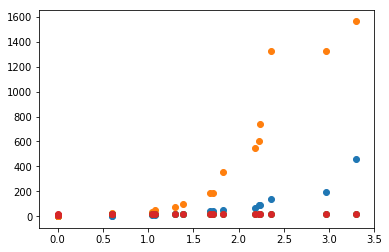

In [115]:
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_uniq_editor)
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_token_length)
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_period)))
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_rate)))

In [40]:
change_grouped_by_tokens.get_group(cluster_ranks_by_period.index.tolist()[0])

ins_tokens del_tokens  \
id                                                                           
750039531 16  (317, -, 2034, -, 9, |, pages, =, 250, –, 251,...  (huawei,)   

                            left_neigh                     right_neigh  \
id                                                                       
750039531 16  (85, 87, 88, 91, 92, 94)  (105, 108, 109, 111, 116, 118)   

                       left_token                            right_token  \
id                                                                         
750039531 16  (/, /, ?, ms, -, -)  (}}, cite, book, last, first, thomas)   

                       timestamp time_gap   editor_s   left_string  \
id                                                                   
750039531 16 2016-11-17 14:28:27 00:03:53  750039992  / / ? ms - -   

                                                     ins_string del_string  \
id                                                                           
750039531 16  317 - 2034 - 9 | pages = 250 – 251 }} < / ref ...     huawei   

                                right_string  ins_token_len  del_token_len  \
id                                                                           
750039531 16  }} cite book last first thomas           6264              1   

              cluster  
id                     
750039531 16        9

In [ ]:
change_grouped_by_tokens.get_group(cluster_ranks_by_period.index.tolist()[0])["del_string"].str.cat()

In [12]:
%%time
silhoutee_s = []
for n in range(2,48,2):
    km = KMeans(n_clusters= n, n_jobs=3)
    clusters = km.fit(ins_del_sum_neighbour_matrix)
    cluster_s = pd.Series(clusters.labels_, index= change_df.index)
    silhoutee_s.append(silhouette_score(change_matrix, cluster_s))

NameError: name 'KMeans' is not defined

ValueError: x and y must have same first dimension, but have shapes (23,) and (0,)

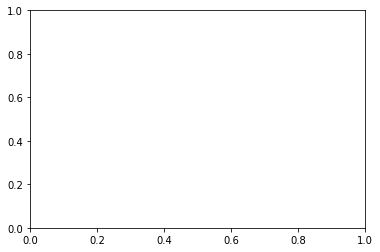

In [13]:
x = np.arange(2,48,2)
plt.plot(x,silhoutee_s)

In [ ]:
x[np.argsort(silhoutee_s)[-8:]]

In [ ]:
np.array(silhoutee_s)[np.argsort(silhoutee_s)[-8:]]

CPU times: user 11.4 s, sys: 32.7 s, total: 44.1 s
Wall time: 57.2 s


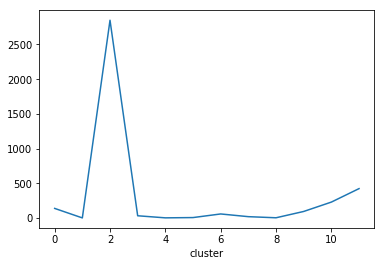

In [165]:
%%time
km = KMeans(n_clusters= 12, n_jobs=3)
clusters = km.fit(ins_del_sum_neighbour_matrix)
cluster_s = pd.Series(clusters.labels_, index= change_df.index)
change_df["cluster"] = cluster_s
change_grouped_by_sum = change_df.groupby("cluster")
change_grouped_by_sum.size().plot()

In [166]:
rank_by_size = change_grouped_by_sum.size().sort_values()
rank_by_size

cluster
1        2
4        3
8        4
5        7
7       20
3       33
6       59
9       95
0      139
10     230
11     424
2     2849
dtype: int64

In [167]:
rank_by_uniq_editor = change_grouped_by_sum["editor_s"].nunique().sort_values()

In [168]:
rank_by_period = change_grouped_by_sum["timestamp"].apply(lambda x: x.max() - x.min()).sort_values()

In [169]:
rank_by_rate = change_grouped_by_sum["time_gap"].apply(lambda x: x.mean()).sort_values()

In [170]:
rank_by_token_length = (change_grouped_by_sum["ins_token_len"].median() + change_grouped_by_sum["del_token_len"].median()).sort_values()
rank_by_token_length = ranks_by_token_length /2

In [ ]:
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_uniq_editor)
plt.scatter(np.log10(cluster_ranks_by_size), rank_by_token_length)
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_period)))
plt.scatter(np.log10(cluster_ranks_by_size), np.log10(pd.to_numeric(rank_by_rate)))

In [ ]:
change_grouped_by_sum.get_group(9)[["del_string", "ins_string"]]